In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

In [3]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')

# The Dataset

Our dataset was obtained from the Census Bureau and has the salaries and demographic variables of 48,842 people. The goal of this decision tree classifier is to predict whether people make more than 50k or less than 50k. In order to prepare our dataset for this model, variables had to be binned.

# Data Quality Analysis

In [4]:
df.head(10)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [6]:
#checking for percent of missing values
df.isna().sum()/len(df)*100
#no missing values found

hours_per_week_bin    0.0
occupation_bin        0.0
msr_bin               0.0
capital_gl_bin        0.0
race_sex_bin          0.0
education_num_bin     0.0
education_bin         0.0
workclass_bin         0.0
age_bin               0.0
flag                  0.0
y                     0.0
dtype: float64

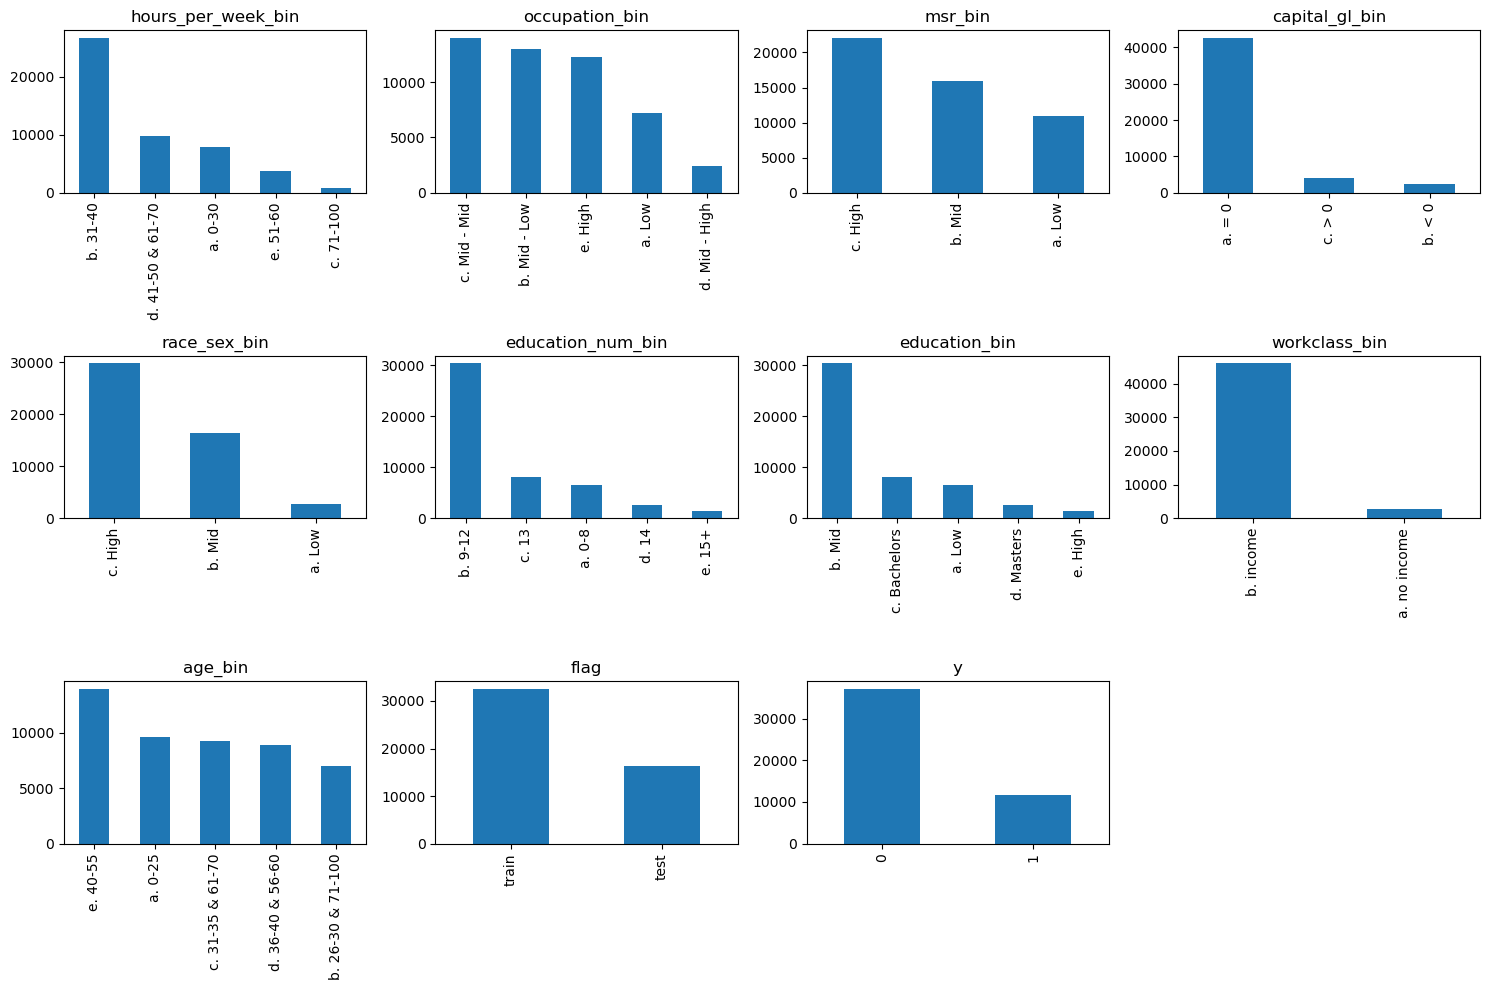

In [7]:
#visualizing the distribution of our columns, using a grid format for
#enhanced readability
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(15,10))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    df[column].value_counts().plot(kind='bar', ax=axes[i], title=column)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Not too much to note about column distributions. The capital gains column seems to be overwhelmingly 0 and the workclass seems to be mostly income. Running some correlation tests can help us determine how useful these kinds of columnsa are.

In [8]:
#descriptive statistics
df.describe(include=[object])

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,5,5,3,3,3,5,5,2,5,2
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561


Our descriptive statistics show us similar trends to our distributions above. We also get a sense of who our average individual from the dataset is.

In [9]:
# checking for imbalances in our target variable, making sure we have enough positives
df['y'].value_counts()/df['y'].count()

# it's 76% negative vs. 23% positive. Not quite the 70/30 split we'd like but there
# are enough records that it shouldn't be too much of a problem

0    0.760718
1    0.239282
Name: y, dtype: float64

In [10]:
# noticing a pattern among the binned variables that they have a., b. or c. in front
# of the values.

df = df.applymap(lambda x: x.split('. ', 1)[-1] if isinstance(x, str) else x)

# this splits at the period after the letter and removes both the period and the letter

In [11]:
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


# Data Quality Report

In [12]:
#generating our data quality report
categorical = df.select_dtypes(include=object)
cols = ['Count', '%Missing', 'Cardinality', 'Mode']
categorical_dqr = pd.DataFrame(columns=cols, index=categorical.columns)

for col in categorical.columns:
    column_data = categorical[col]
    count = column_data.count()
    missing = column_data.isna().sum()/len(categorical)*100
    cardinality = column_data.nunique()
    mode = column_data.mode().iloc[0]
    categorical_dqr.loc[col, ['Count', '%Missing', 'Cardinality', 'Mode']] = [count, missing, cardinality, mode]
categorical_dqr

,Count,%Missing,Cardinality,Mode
hours_per_week_bin,48842,0.0,5,31-40
occupation_bin,48842,0.0,5,Mid - Mid
msr_bin,48842,0.0,3,High
capital_gl_bin,48842,0.0,3,= 0
race_sex_bin,48842,0.0,3,High
education_num_bin,48842,0.0,5,9-12
education_bin,48842,0.0,5,Mid
workclass_bin,48842,0.0,2,income
age_bin,48842,0.0,5,40-55
flag,48842,0.0,2,train


From our data quality report we once again see none of our columns have missing values and our cardinality and modes look healthy.

# Encoding

In order to prepare the dataset for the model and test correlations I will encode it. Based on the feature types, like ordinal or nominal, I will encode them with either ordinal encoding or one-hot encoding.

In [13]:
ordinal_cols = ["education_num_bin", "hours_per_week_bin", "capital_gl_bin", "age_bin"]
one_hot_cols = ["education_bin", "occupation_bin", "msr_bin", "race_sex_bin", "workclass_bin"]

I'm placing columns in the ordinal_cols list based on what their values look like. I'm not sure why there would be a low, medium, and high for occupation or race sex but the variables show that there is some order. The one hot cols list are the rest of the columns minus the y and the flag columns.

In [14]:
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

In [15]:
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)

# Correlations

In [16]:
# dropping flag as we're splitting on this and getting rid of it as soon as our
# data is ready
df_for_corr = df.drop('flag', axis=1)

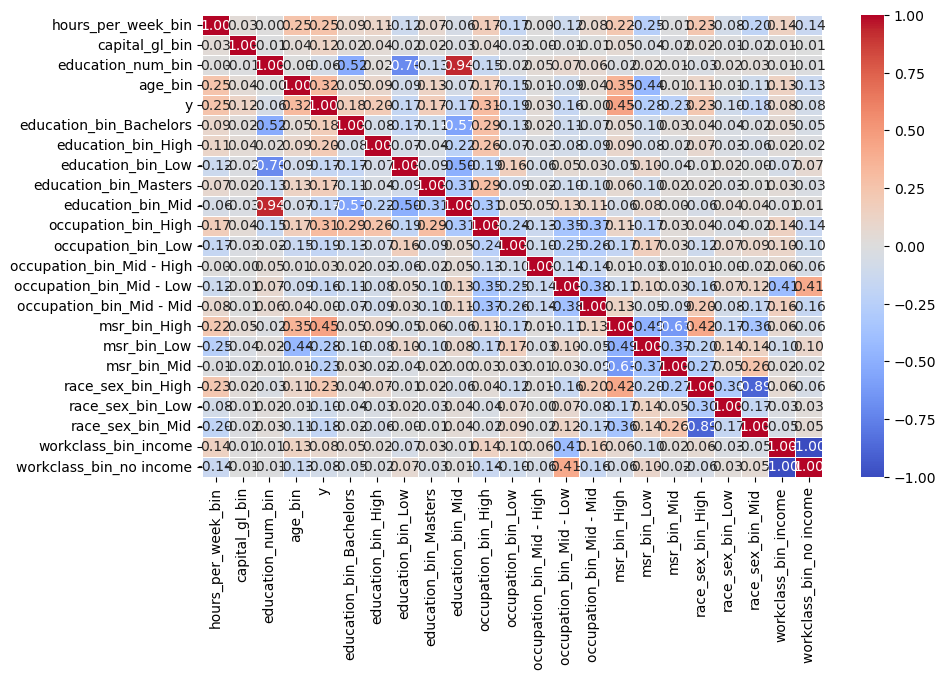

In [17]:
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(df_for_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

We see some high correlations among different levels of the same variable which aren't too much of a surprise. However, our education_num_bin and our education_bin are two seperate columns essentially saying the same thing now that they're encoded. I will stick with education_bin for easier interpretability.

In [18]:
df.drop('education_num_bin', axis=1, inplace=True)

In [19]:
# a last look at our cleaned and transformed dataset before splitting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hours_per_week_bin         48842 non-null  float64
 1   capital_gl_bin             48842 non-null  float64
 2   age_bin                    48842 non-null  float64
 3   flag                       48842 non-null  object 
 4   y                          48842 non-null  int64  
 5   education_bin_Bachelors    48842 non-null  uint8  
 6   education_bin_High         48842 non-null  uint8  
 7   education_bin_Low          48842 non-null  uint8  
 8   education_bin_Masters      48842 non-null  uint8  
 9   education_bin_Mid          48842 non-null  uint8  
 10  occupation_bin_High        48842 non-null  uint8  
 11  occupation_bin_Low         48842 non-null  uint8  
 12  occupation_bin_Mid - High  48842 non-null  uint8  
 13  occupation_bin_Mid - Low   48842 non-null  uin

# Splitting the data

splitting the data based on the flag column and then splitting into our X and our y

In [20]:
train_df = df[df['flag'] == 'train'].drop(columns=['flag'])
test_df = df[df['flag'] == 'test'].drop(columns=['flag'])

In [21]:
X_train = train_df.drop(columns=['y'])
y_train = train_df['y']

In [22]:
X_test = test_df.drop(columns=['y'])
y_test = test_df['y']

# Building Random Forest Classifier

Starting with the default parameters to get a baseline for our models performance.

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

Let's start by looking at our confusion matrix.

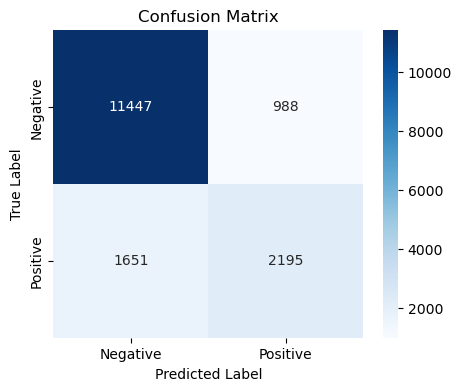

In [24]:
def confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
confusion(y_test, y_pred)

In [25]:
def performance(y_test, y_pred):    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Auc" : auc
    }

performance(y_test, y_pred)

{'Accuracy': 0.8379092193354216,
 'Precision': 0.6896010053408734,
 'Recall': 0.5707228289131565,
 'F1 Score': 0.6245554132878076,
 'Auc': 0.7456348362499036}

Our model has good overall accuracy but poor recall, meaning we are missing alot of our positives. Our F1 score is moderate but certainly has room for improvement. Next we will do some hyper parameter tuning, specifically with n_estimators, to see if we can improve these metrics.

# Random Forest Hyper Parameter Tuning

These are the n_estimator values we will be using for the hyper parameter tuning of all our models:

In [26]:
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [27]:
results = []
for estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators = estimators)
    rf.fit(X_train, y_train)
    y_pred=rf.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["n_estimators"] = estimators
    results.append(metrics)

df_run1 = pd.DataFrame(results)
print("Run 1 Results:\n", df_run1)


Run 1 Results:
    Accuracy  Precision    Recall  F1 Score       Auc  n_estimators
0  0.836988   0.688608  0.565783  0.621182  0.743326            50
1  0.837541   0.689015  0.569163  0.623380  0.744855           100
2  0.838093   0.690852  0.569423  0.624287  0.745306           150
3  0.837172   0.689382  0.565523  0.621340  0.743356           200
4  0.836804   0.687244  0.567343  0.621564  0.743744           250
5  0.837356   0.688959  0.567863  0.622577  0.744285           300
6  0.837111   0.688685  0.566563  0.621683  0.743675           350
7  0.837295   0.686623  0.572543  0.624415  0.745861           400
8  0.837049   0.686815  0.570203  0.623100  0.744892           450
9  0.837664   0.688854  0.570463  0.624093  0.745384           500


In [28]:
def n_estimator_graph(df):
    fig, axes = plt.subplots(1, 2, figsize = (14, 5))
    axes[0].plot(df['n_estimators'], df['Accuracy'], marker='o', color='blue', label='Accuracy')
    axes[0].set_title('n_estimators vs. Accuracy')
    axes[0].set_xlabel('n_estimators')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    axes[0].legend()
    axes[1].plot(df['n_estimators'], df['Auc'], marker='o', color='green', label='AUC')
    axes[1].set_title('n_estimators vs. AUC')
    axes[1].set_xlabel('n_estimators')
    axes[1].set_ylabel('AUC')
    axes[1].grid(True)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

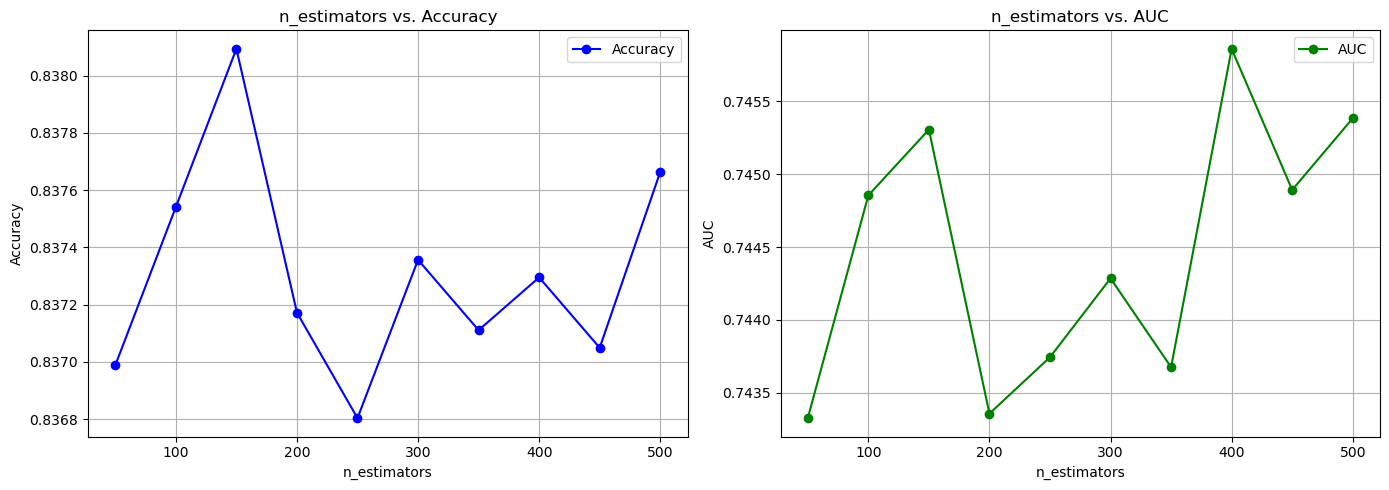

In [29]:
n_estimator_graph(df_run1)

1. n_estimators has a slight effect on both accuracy and AUC. However, in the grand scheme of things the effect is middling at best. Our accuracy ranges from .836 to .838 with AUC showing a similarly miniscule range from .743 to .745. Perhaps tuning the model on another hyper parameter may have a greater effect on overall performance.

2. It seems the optimal performance happens at around 150 for n_estimators if we are trying to balance accuracy and AUC. This is the point at which both are fairly high. Although AUC peaks at 400 estimators, accuracy isn't as high at this point.

# Building AdaBoost Classifier

Again, starting with the default parameters to see where our baseline is in terms of performance.

In [30]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
y_pred=ab.predict(X_test)

/Users/tommyropp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


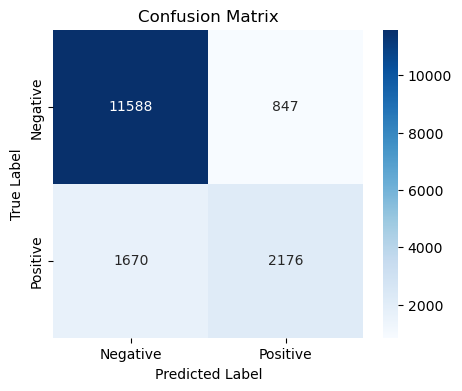

In [31]:
confusion(y_test, y_pred)

In [32]:
performance(y_test, y_pred)

{'Accuracy': 0.8454026165468952,
 'Precision': 0.7198147535560702,
 'Recall': 0.5657826313052522,
 'F1 Score': 0.6335711166108604,
 'Auc': 0.7488342187487258}

Similar to Random Forest we have decent precision but poor recall and a moderate F1 score. Our AUC is also about the same as Random Forest.

# AdaBoost Hyperparameter Tuning

In [33]:
results = []
for estimators in n_estimators:
    ab = AdaBoostClassifier(n_estimators = estimators)
    ab.fit(X_train, y_train)
    y_pred=rf.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["n_estimators"] = estimators
    results.append(metrics)

df_run2 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run2)

/Users/tommyropp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tommyropp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tommyropp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/tommyropp/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to ci

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score       Auc  n_estimators
0  0.837664   0.688854  0.570463  0.624093  0.745384            50
1  0.837664   0.688854  0.570463  0.624093  0.745384           100
2  0.837664   0.688854  0.570463  0.624093  0.745384           150
3  0.837664   0.688854  0.570463  0.624093  0.745384           200
4  0.837664   0.688854  0.570463  0.624093  0.745384           250
5  0.837664   0.688854  0.570463  0.624093  0.745384           300
6  0.837664   0.688854  0.570463  0.624093  0.745384           350
7  0.837664   0.688854  0.570463  0.624093  0.745384           400
8  0.837664   0.688854  0.570463  0.624093  0.745384           450
9  0.837664   0.688854  0.570463  0.624093  0.745384           500


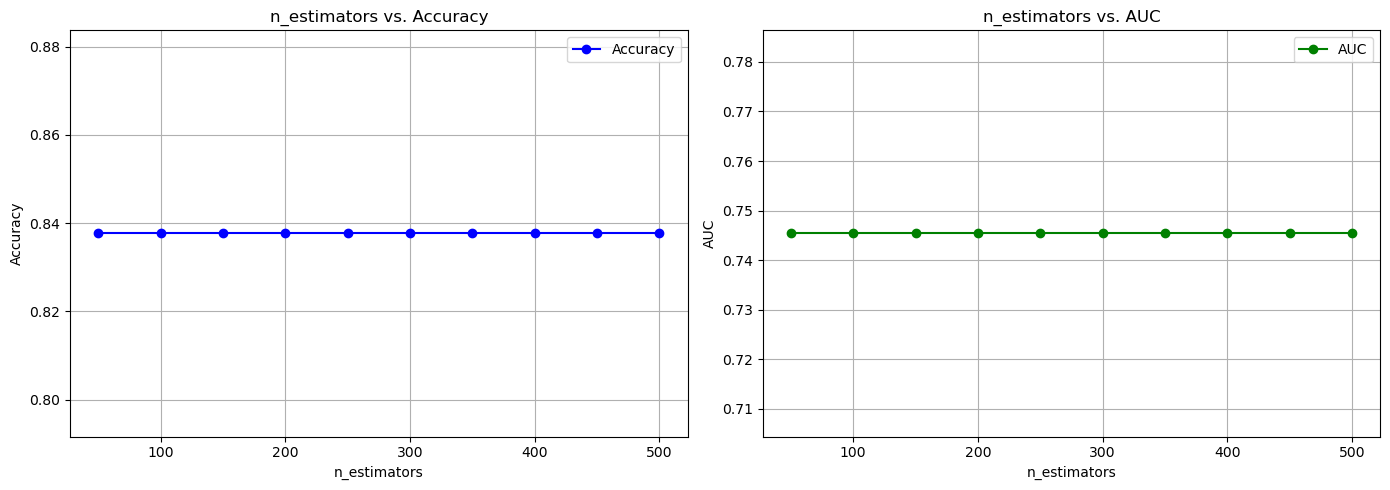

In [34]:
n_estimator_graph(df_run2)

1. We see that n_estimators has no effect on model performance. One reason this could be happending with AdaBoost is that it is achieving optimal performance fairly early on which means that adding more estimators does not improve the model further.

2. It seems the optimal point for n_estimators is 50 as past this point there is no effect on model performance.

# Building Gradient Boost Classifier

In [35]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred=gb.predict(X_test)

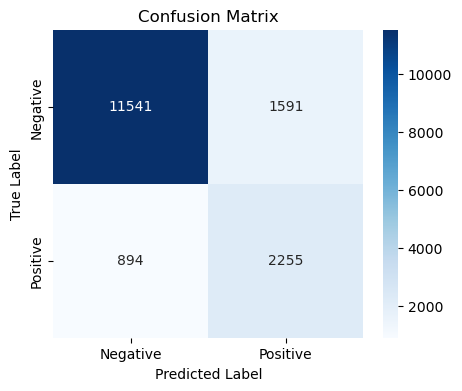

In [36]:
confusion(y_pred, y_test)

In [37]:
performance(y_pred, y_test)

{'Accuracy': 0.8473680977826915,
 'Precision': 0.5863234529381175,
 'Recall': 0.7161003493172435,
 'F1 Score': 0.6447462473195139,
 'Auc': 0.7974729586976105}

Here we see that Gradient Boosting is having the opposite effect when compared to both AdaBoost and Random Forest. Precision is low but recall is higher signaling that we are getting alot of false positives. AUC has improved when compared to the past two models.

# Gradient Boost Hyperparameter Tuning

In [38]:
results = []
for estimators in n_estimators:
    gb = GradientBoostingClassifier(n_estimators = estimators)
    gb.fit(X_train, y_train)
    y_pred=gb.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["n_estimators"] = estimators
    results.append(metrics)

df_run3 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run3)

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score       Auc  n_estimators
0  0.846263   0.734872  0.546282  0.626696  0.742662            50
1  0.847368   0.716100  0.586323  0.644746  0.757215           100
2  0.847491   0.714511  0.590224  0.646447  0.758642           150
3  0.846815   0.709158  0.595944  0.647641  0.760175           200
4  0.847122   0.710127  0.596204  0.648198  0.760466           250
5  0.846447   0.709657  0.592304  0.645692  0.758677           300
6  0.846692   0.708076  0.597244  0.647955  0.760544           350
7  0.846692   0.707692  0.598024  0.648253  0.760813           400
8  0.846570   0.707257  0.598024  0.648070  0.760733           450
9  0.846263   0.706171  0.598024  0.647614  0.760532           500


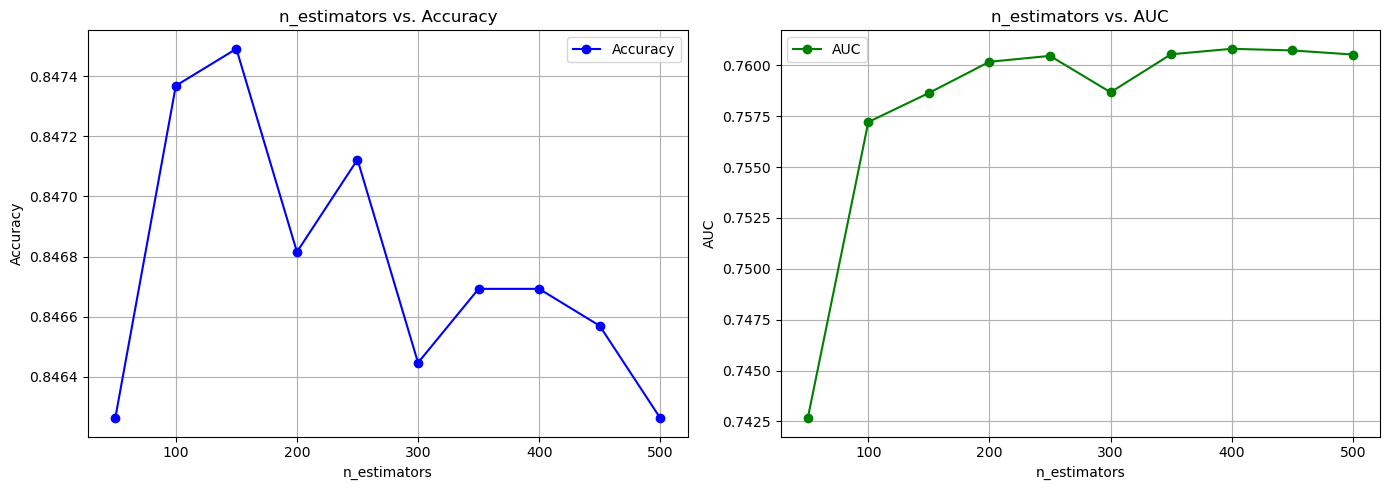

In [39]:
n_estimator_graph(df_run3)

1. Interestingly enough, despite gradient boosting also being a boosting model, n_estimators does have an effect on model performance unlike AdaBoost. The improvement for accuracy is not as large as it is for AUC which ranges from .74 to .76.

2. It seems that the optimal point for n_estimators is either 150 or 250 depending on the metric you want to maximize. I would personally go for 250 as I think AUC is a better measure of a models true performance. At 250 we maximize AUC while also getting one of the higher accuracy scores across all n_estimator values.

# Building XGBoost Classifier

XGBoost has strict requirements on characters that are allowed in columns with data types having to be consistent across the dataset. This requires some pre processing before running the model.

In [40]:
#removing characters that XGBoost doesn't like
X_train.columns = X_train.columns.str.replace(r'[<>=&]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[<>=&]', '_', regex=True)

In [41]:
X_train.columns = [f"{col}_{i}" if X_train.columns.duplicated()[i] else col for i, col in enumerate(X_train.columns)]
X_test.columns = [f"{col}_{i}" if X_test.columns.duplicated()[i] else col for i, col in enumerate(X_test.columns)]

In [42]:
#changing all types to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [43]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred=xgb_model.predict(X_test)

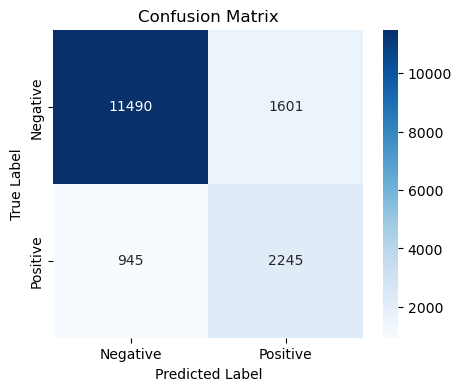

In [44]:
confusion(y_pred, y_test)

In [45]:
performance(y_pred, y_test)

{'Accuracy': 0.8436213991769548,
 'Precision': 0.5837233489339574,
 'Recall': 0.7037617554858934,
 'F1 Score': 0.6381466742467311,
 'Auc': 0.7907319968323975}

Our best AUC of the 4 models but F1 remains about the same.

# XGBoost Hyperparameter Tuning

In [46]:
results = []
for estimators in n_estimators:
    xgb_model = xgb.XGBClassifier(n_estimators = estimators)
    xgb_model.fit(X_train, y_train)
    y_pred=xgb_model.predict(X_test)
    metrics = performance(y_test, y_pred)
    metrics["n_estimators"] = estimators
    results.append(metrics)

df_run4 = pd.DataFrame(results)
print("Run 2 Results:\n", df_run4)

Run 2 Results:
    Accuracy  Precision    Recall  F1 Score       Auc  n_estimators
0  0.845280   0.708190  0.586843  0.641831  0.756027            50
1  0.843621   0.703762  0.583723  0.638147  0.753864           100
2  0.842762   0.700187  0.584763  0.637291  0.753660           150
3  0.842454   0.699099  0.584763  0.636840  0.753459           200
4  0.841472   0.697102  0.581643  0.634160  0.751738           250
5  0.841349   0.695571  0.583983  0.634912  0.752466           300
6  0.841042   0.694616  0.583723  0.634360  0.752175           350
7  0.840919   0.696496  0.578783  0.632207  0.750389           400
8  0.840305   0.693599  0.580343  0.631937  0.750525           450
9  0.840305   0.693599  0.580343  0.631937  0.750525           500


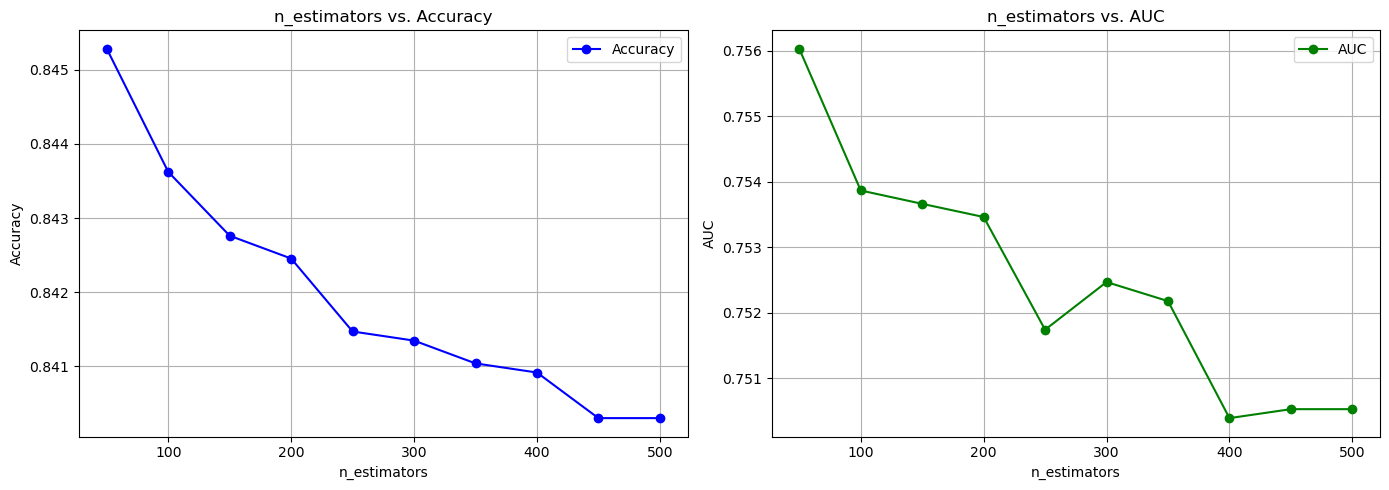

In [47]:
n_estimator_graph(df_run4)

1. It seems that n_estimators has a diminishing effect on both accuracy and AUC. After 50 both performance metrics fall, although within a fairly small range.

2. The optimal point for n_estimators for this model is 50 as performance declines after this point.

# Comparing Performance

In [50]:
# creating a df that compares performance metrics with the optimal n_estimator points for each model

#optimal n_estimators for each model we decided on
optimal_n_estimators = {
    'Random Forest': 150,
    'AdaBoost': 50,
    'Gradient Boost': 250,
    'XGBoost': 50
}
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC']
})
#performance metric dfs we created for our different models
model_dfs = {
    'Random Forest': df_run1,
    'AdaBoost': df_run2,
    'Gradient Boost': df_run3,
    'XGBoost': df_run4
}
for model, df in model_dfs.items():
    n_estimators = optimal_n_estimators[model]
    optimal_row = df[df['n_estimators'] == n_estimators].iloc[0]

    comparison_df[model] = [optimal_row['Accuracy'], optimal_row['Auc']]
comparison_df.set_index('Metric', inplace=True)
print(comparison_df)


          Random Forest  AdaBoost  Gradient Boost   XGBoost
Metric                                                     
Accuracy       0.838093  0.837664        0.847122  0.845280
AUC            0.745306  0.745384        0.760466  0.756027
